# Desa Sentinel 10m ES

Kode modelling klasifikasi densenet dan resnet IDM pada data sentinel 2 10m dengan neighbor Square, input tingkat desa.

In [1]:
import fastai
from fastai.vision.all import *
import os
from PIL import Image
import pandas as pd
import shutil
import torch

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

#### Preprocessing

In [3]:
idm = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/newdata_edit.csv")

In [4]:
idm = idm.drop_duplicates("bps_kelurahan_kode")

In [5]:
idm.groupby("status").count()

,kemendagri_kelurahan_kode,bps_kelurahan_kode,bps_kelurahan_nama,kemendagri_kelurahan_nama,id,kemendagri_provinsi_kode,kemendagri_kota_kode,kemendagri_kecamatan_kode,kemendagri_provinsi_nama,kemendagri_kota_nama,...,status_adm,nama,id_kecamatan,nama_kecamatan,id_kabupaten,nama_kabupaten,iks,ike,ikl,avg_idm
status,,,,,,,,,,,,,,,,,,,,,
BERKEMBANG,3290,3290,3223,3290,3290,3290,3290,3290,3290,3290,...,0,3290,3290,3290,3290,3290,3290,3290,3290,3290
MAJU,1631,1631,1584,1631,1631,1631,1631,1631,1631,1631,...,0,1631,1631,1631,1631,1631,1631,1631,1631,1631
MANDIRI,270,270,267,270,270,270,270,270,270,270,...,0,270,270,270,270,270,270,270,270,270
TERTINGGAL,121,121,119,121,121,121,121,121,121,121,...,0,121,121,121,121,121,121,121,121,121


In [6]:
idm[idm.bps_kelurahan_kode ==3209100011]

,kemendagri_kelurahan_kode,bps_kelurahan_kode,status,bps_kelurahan_nama,kemendagri_kelurahan_nama,id,kemendagri_provinsi_kode,kemendagri_kota_kode,kemendagri_kecamatan_kode,kemendagri_provinsi_nama,...,status_adm,nama,id_kecamatan,nama_kecamatan,id_kabupaten,nama_kabupaten,iks,ike,ikl,avg_idm
3070,3209132011,3.209100e+09,MAJU,NaN,BEBER,3038,32,32.09,32.09.13,JAWA BARAT,...,NaN,BEBER,320913.0,BEBER,3209.0,KABUPATEN CIREBON,0.8629,0.8,0.6667,0.7765


In [7]:
3290+1631+270+121

5312

In [29]:
os.chdir('C:/Users/jwst2/Python/tesis/jpg/IDM/02. Desa Sentinel 10m ES')
if os.path.isdir('jabar_idm/MAJU') is False:
    os.makedirs('MAJU MANDIRI')
    os.makedirs('TERTINGGAL BERKEMBANG')


In [30]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/general desa sentinel ES/"
destpath = 'C:/Users/jwst2/Python/tesis/jpg/IDM/02. Desa Sentinel 10m ES'

In [31]:

from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        if(not idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].empty):
            if(idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].iloc[0] == "MAJU"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
            elif(idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].iloc[0] == "BERKEMBANG"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].iloc[0] == "TERTINGGAL"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].iloc[0] == "MANDIRI"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
       

1it [00:20, 20.66s/it]


#### Models

In [32]:
path = Path.cwd() / (destpath)

In [33]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('MAJU MANDIRI'),Path('TERTINGGAL BERKEMBANG')]

In [34]:
fname = (path/"TERTINGGAL BERKEMBANG").ls()[0]
fname

Path('TERTINGGAL BERKEMBANG/3201010001.jpg')

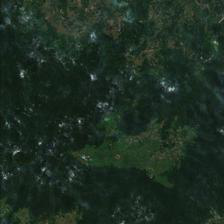

In [35]:
img = Image.open(fname)
img

In [36]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(0.1,seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)

In [37]:
dls = blocks.dataloaders(path,bs= 10)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


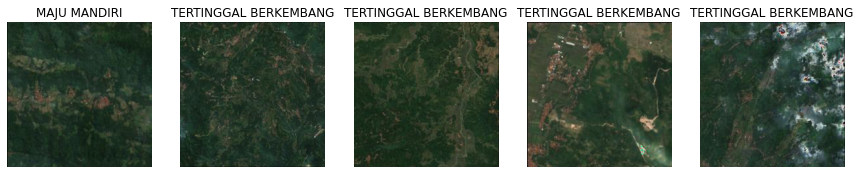

In [38]:
dls.show_batch(nrows=1, ncols=5)

#### Densenet

In [39]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s,roca]

In [40]:
learn = cnn_learner(dls, densenet121, metrics=metrics) 

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.0005754399462603033)

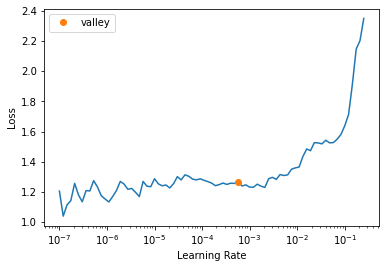

In [41]:
learn.lr_find()

In [42]:
learn.fit_one_cycle(5, lr_max = 1e-2)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.989277,0.850134,0.615819,0.594373,0.587893,0.594373,0.588422,0.597974,01:55
1,0.853786,0.909133,0.613936,0.567236,0.567797,0.567236,0.567495,0.622555,01:51
2,0.721600,0.611530,0.683616,0.634829,0.642502,0.634829,0.637719,0.684362,01:55
3,0.610617,0.581178,0.704331,0.603134,0.678765,0.603134,0.601231,0.702928,01:57
4,0.579219,0.579185,0.721281,0.649786,0.689657,0.649786,0.657598,0.710557,01:56


In [46]:
learn.fit_one_cycle(1, lr_max = 1e-2)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.613275,0.586443,0.725047,0.655342,0.694470,0.655342,0.663562,0.706062,01:44


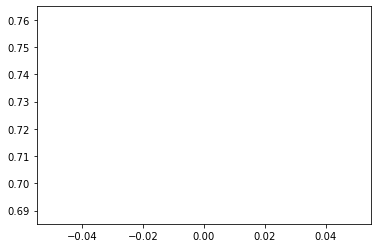

In [47]:
plt.plot(L(learn.recorder.values).itemgot(2));

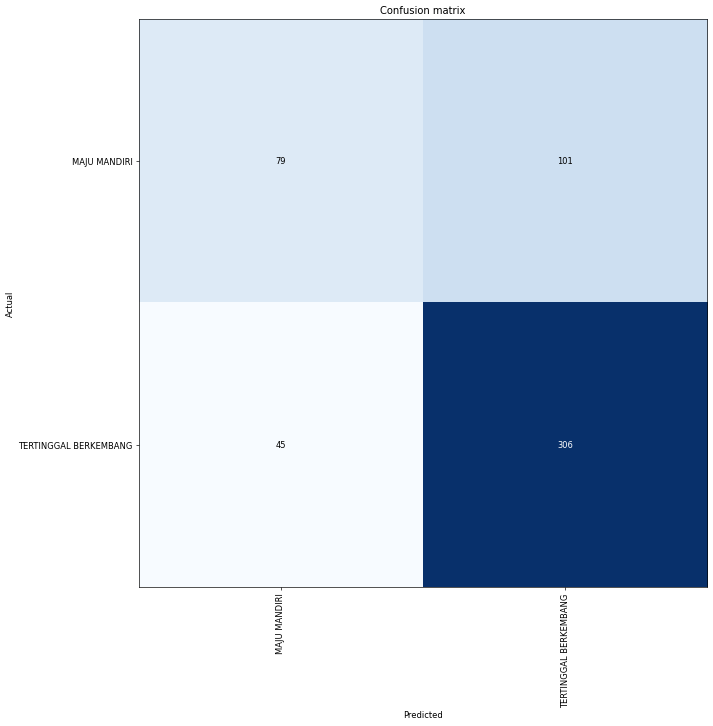

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.plot_top_losses(6, figsize=(15,11))

In [50]:
learn.export('C:/Users/jwst2/Python/tesis/idm/models/Desa densenet sentinel 10m ES.pkl')

#### Resnet

In [51]:
learn_rs = cnn_learner(dls, resnet50, metrics=metrics) 

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.0004786300996784121)

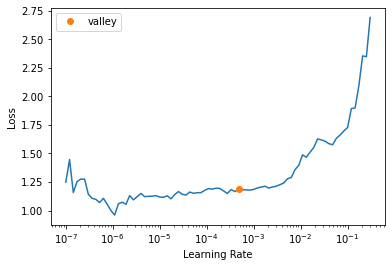

In [52]:
learn_rs.lr_find()

In [53]:
learn_rs.fit_one_cycle(5, lr_max = 1e-2)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.079857,1.107240,0.499058,0.545299,0.543497,0.545299,0.498544,0.571985,01:23
1,1.028472,0.654164,0.644068,0.544017,0.568272,0.544017,0.534074,0.597974,01:26
2,0.768884,0.643538,0.659134,0.573006,0.598938,0.573006,0.571623,0.613406,01:35
3,0.672678,0.618835,0.677966,0.548006,0.644539,0.548006,0.514685,0.673678,01:42
4,0.614041,0.581758,0.706215,0.611325,0.677211,0.611325,0.612626,0.705492,01:44


In [54]:
learn_rs.fit_one_cycle(1, lr_max = 1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.609886,0.577554,0.706215,0.616738,0.673811,0.616738,0.619935,0.706964,01:42


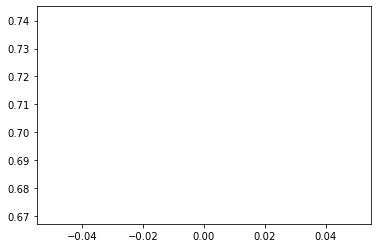

In [55]:
plt.plot(L(learn_rs.recorder.values).itemgot(2));

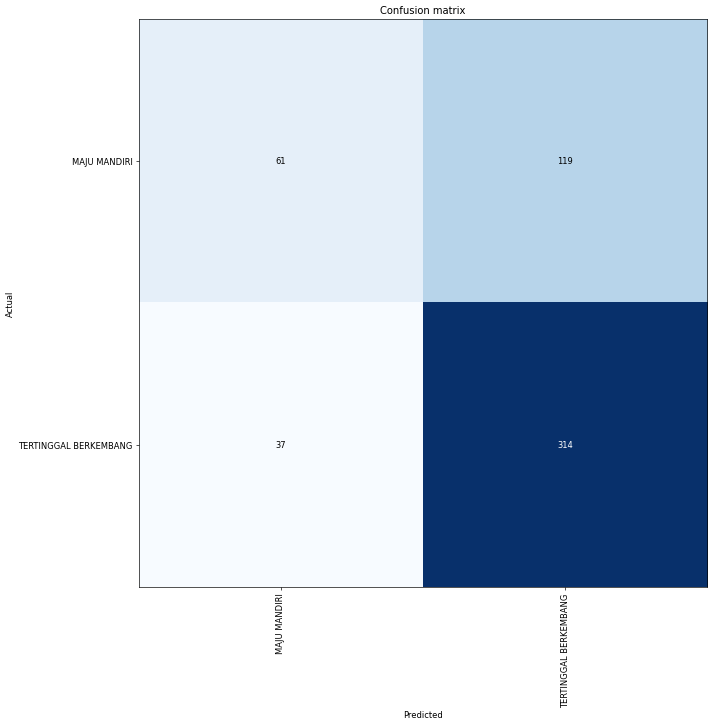

In [56]:
interp = ClassificationInterpretation.from_learner(learn_rs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [57]:
learn_rs.export('C:/Users/jwst2/Python/tesis/idm/models/Desa resnet sentinel 10m ES.pkl')

In [ ]:
interp.plot_top_losses(16, figsize=(15,11))